Model training!

In [1]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *

def modify_data():
    df = pd.read_csv('train.csv')
    df.dropna(subset=['Age'], inplace=True)
    df['Survived'] = df['Survived'].astype('category')
    df['class_x_sex'] = df['Pclass'].astype(str) + '_' + df['Sex']
    df['Fare_log'] = np.log1p(df['Fare'])
    procs = [Categorify, FillMissing, Normalize]
    path = '.'     
    cat_names  = ['Sex','Pclass','Embarked','class_x_sex','SibSp','Parch']
    cont_names = ['Fare_log','Age']
    
    return build_base(df, procs, cat_names, cont_names, path)

def build_base(df,procs,cat_names,cont_names,path = '.' ):

    dls = TabularDataLoaders.from_df(
        df, 
        path='.', 
        procs=procs,
        cat_names=cat_names, 
        cont_names=cont_names,
        y_names='Survived',
        val_shuffle=True,
        splits=RandomSplitter(0.2)(range_of(df))
    )

    learn = tabular_learner(
        dls,
        metrics=[accuracy],
        loss_func=CrossEntropyLossFlat() 
    )

    print("x_names:", learn.dls.train_ds.x_names)
    print("y_names:", learn.dls.train_ds.y_names)

    return learn, dls

def fit_one(epoch,learn,slice1,slice2):
    e = epoch
    learn.fit_one_cycle(e,slice(slice1, slice2))
    learn.recorder.plot_loss()

def get_valid_data(learn, dls):
    res = learn.validate()
    valid_loss, accuracy = res[0], res[1]
    print(f"Validation accuracy:  {accuracy*100:.2f}%")
    print(f"Validation error rate: {(1-accuracy)*100:.2f}%")

    # steps per epoch
    steps_per_epoch = len(dls.train)
    print(f"{steps_per_epoch=} batches/epoch")

    # if you’re going to train n_epochs
    n_epochs = 5
    total_steps = steps_per_epoch * n_epochs
    print(f"{total_steps=} total training steps")

    # run the finder
    learn.lr_find()

learn, dls = modify_data()

x_names: ['Sex', 'Pclass', 'Embarked', 'class_x_sex', 'SibSp', 'Parch', 'Fare_log', 'Age']
y_names: ['Survived']


SuggestedLRs(valley=0.0006918309954926372)

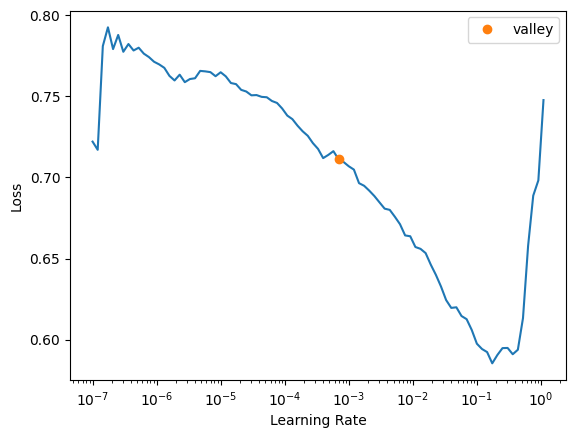

In [2]:
learn.lr_find()

fit_one(6, learn, 1e-3, 1e-2)
epoch	train_loss	valid_loss	accuracy	time

0	0.672212	0.635953	0.711268	00:00
1	0.600438	0.607645	0.605634	00:00
2	0.547603	0.484247	0.802817	00:00
3	0.500596	0.469872	0.859155	00:00
4	0.467530	0.408349	0.852113	00:00
5	0.436518	0.495027	0.816901	00:00

epoch,train_loss,valid_loss,accuracy,time
0,0.656633,0.653613,0.669014,00:00
1,0.635252,0.554546,0.690141,00:00
2,0.574716,0.529867,0.781690,00:00
3,0.540253,0.467865,0.880282,00:00


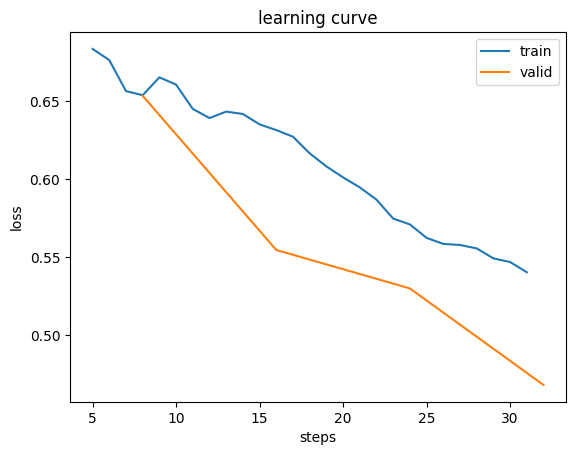

In [2]:
fit_one(4, learn, 1e-3, 1e-2)

Validation accuracy:  85.92%
Validation error rate: 14.08%
steps_per_epoch=8 batches/epoch
total_steps=40 total training steps


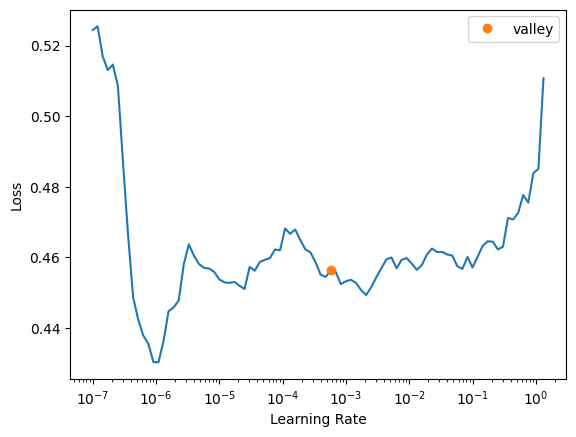

In [3]:
get_valid_data(learn,dls)

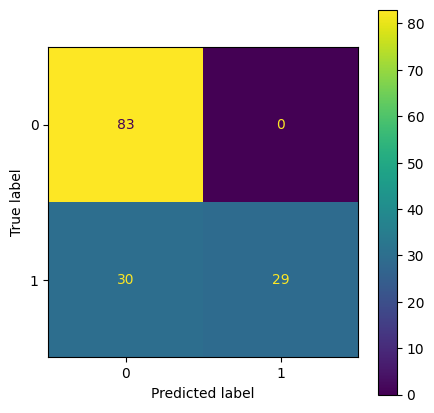

Total misclassified: 30


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,class_x_sex,Fare_log,predicted,actual
224,225,1,1,"Hoyt, Mr. Frederick Maxfield",2,0.565461,2,1,19943,90.000000,C93,3,2,1.559497,0,1
418,419,0,2,"Matthews, Mr. William John",2,0.007418,1,1,28228,13.000000,NaN,3,4,-0.423489,0,1
664,665,1,3,"Lindqvist, Mr. Eino William",2,-0.690135,2,1,STON/O 2. 3101285,7.925000,NaN,3,6,-0.900432,0,1
591,592,1,1,"Stephenson, Mrs. Walter Bertram (Martha Eustis)",1,1.542036,2,1,36947,78.266701,D20,1,1,1.413256,0,1
704,705,0,3,"Hansen, Mr. Henrik Juul",2,-0.271603,2,1,350025,7.854200,NaN,3,6,-0.908869,0,1


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import pandas as pd

# 1. Get model outputs & true targets on the valid set
probs_val, targs_val = learn.get_preds(dl=learn.dls.valid)
# ——> probs_val: (n_valid, n_classes) or (n_valid,1) if regressor
# ——> targs_val: (n_valid,)

# 2. Turn those into hard labels
# If you have a 2‐class softmax head:
preds_class = (probs_val.argmax(dim=1))

# 3. Compute & plot the confusion matrix
cm = confusion_matrix(targs_val.cpu(), preds_class.cpu())

fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(ax=ax)
plt.show()

# 4. Grab your original valid‐set DataFrame
valid_df = learn.dls.valid.dataset.items.copy()

# 5. Annotate with predictions and ground truth
valid_df['predicted'] = preds_class.numpy()
valid_df['actual']    = targs_val.numpy()

# 6. Filter to only the misclassified rows
misclassified = valid_df[valid_df['predicted'] != valid_df['actual']]

# 7. Inspect
print(f"Total misclassified: {len(misclassified)}")
misclassified.head()


In [6]:
df = misclassified.copy()
not_dead = df[df['predicted'] == 1]
count_nd_female = (not_dead['Sex'] ==2).sum()
print(f"count of not dead females: {count_nd_female}")


dead = df[df['predicted'] == 0]
count_d_female = (dead['Sex'] ==2).sum()
print(f"count of dead females: {count_d_female}")

count of not dead females: 0
count of dead females: 20


In [7]:
males_misclassified = (df['Sex'] == 1).sum()
print(f"count of misclassified males = {males_misclassified}")

count of misclassified males = 10


In [5]:
learn.export('titanic_model_v4.1.pkl')